## Import and Configuration

In [38]:
import os
import re
import csv
import json
import math
import openai
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from datetime import datetime
from collections import defaultdict, Counter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap

In [39]:
def extract_brackets(text, brackets='[]'):
    assert len(brackets) == 2
    pattern = re.escape(brackets[0]) + r'(.*?)' + re.escape(brackets[1])
    matches = re.findall(pattern, text)
    return matches

def extract_amout(
    message, 
    prefix='',
    print_except=True,
    type=float,
    brackets='[]'
):
    try:
        matches = extract_brackets(message, brackets=brackets)
        matches = [s[len(prefix):] \
            if s.startswith(prefix) \
            else s for s in matches]
        invalid = False
        if len(matches) == 0:
            invalid = True
        for i in range(len(matches)):
            if matches[i] != matches[0]:
                invalid = True
        if invalid:
            raise ValueError('Invalid answer: %s' % message)
        return type(matches[0])
    except Exception as e: 
        if print_except: print(e)
        return None

def extract_choices(records):
    choices = [extract_amout(
        messages[-1]['content'], 
        prefix='$', 
        print_except=True,
        type=float) for messages in records['messages']
    ]
    choices = [x for x in choices if x is not None]
    # print(choices)
    return choices

In [40]:
def choices_to_df(choices, hue):
    df = pd.DataFrame(choices, columns=['choices'])
    df['hue'] = hue
    df['hue'] = df['hue'].astype(str)
    return df

def plot(
        df, 
        title='',
        x='choices',
        hue='hue',
        binrange=None, 
        binwidth=None,
        stat='count',
        multiple='dodge'
    ):
    if binrange is None:
        binrange = (df[x].min(), df[x].max())
    df = df.dropna(axis=0, subset=[x]).reset_index()
    plt.figure(figsize=(8, 6))
    ax = sns.histplot(
        data=df, 
        x=x,
        hue=hue, 
        kde=True,
        binrange=binrange, 
        binwidth=binwidth,
        stat=stat,
        multiple=multiple,
        shrink=.8,
    )
    ax.set_title(title)
    return ax

In [41]:
def plot_facet(
    df_list,
    x='choices',
    hue='hue',
    palette=None,
    binrange=None,
    bins=10,
    # binwidth=10,
    stat='count',
    x_label='',
    sharex=True,
    sharey=False,
    subplot=sns.histplot,
    xticks_locs=None,
    # kde=False,
    **kwargs
):
    data = pd.concat(df_list)
    if binrange is None:
        binrange = (data[x].min(), data[x].max())
    g = sns.FacetGrid(
        data, row=hue, hue=hue, 
        palette=palette,
        aspect=2, height=2, 
        sharex=sharex, sharey=sharey,
        despine=True,
    )
    g.map_dataframe(
        subplot, 
        x=x, 
        # kde=kde, 
        binrange=binrange, 
        bins=bins,
        stat=stat,
        **kwargs
    )
    # g.add_legend(title='hue')
    g.set_axis_labels(x_label, stat.title())
    g.set_titles(row_template="{row_name}")
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(
            FuncFormatter(lambda y, pos: '{:.2f}'.format(y))
        )
    
    binwidth = (binrange[1] - binrange[0]) / bins
    if xticks_locs is None:
        locs = np.linspace(binrange[0], binrange[1], bins//2+1)
        locs = [loc + binwidth for loc in locs]
    else: 
        locs = xticks_locs
    labels = [str(int(loc)) for loc in locs]
    locs = [loc + 0.5*binwidth for loc in locs]
    plt.xticks(locs, labels)
    
    g.set(xlim=binrange)
    return g

In [42]:
sns.set(rc={'figure.figsize':(5,4)})
sns.set_style("ticks")

default_palette = sns.color_palette(None)
blue = default_palette[0]
orange = default_palette[1]
green = default_palette[2]
red = default_palette[3]
purple = default_palette[4]

In [43]:
def plot_occupations(
    df_baseline,
    choices_all,
    binrange=(0,100),
    binwidth=5,
    x_label='$ to give',
    stat='density',
    model='ChatGPT-4',
):
    print('baseline: ', len(df_baseline))
    df_list = []
    for occupation in choices_all:
        choices = choices_all[occupation]
        print(occupation, ':', len(choices))
        df = choices_to_df(choices, hue='{} ({})'.format(model, occupation))
        df_list.append(df)
    g = plot_facet(
        df_list=[df_baseline]+df_list,
        binrange=binrange,
        binwidth=binwidth,
        x_label=x_label,
        stat=stat,
    )
    return g

## Fig. 1: Big Five

### Human Data

In [44]:
bigfive_human_data = pd.read_csv('data/bigfive_data.csv', delimiter='\t')
bigfive_human_data['hue'] = 'Human'
bigfive_human_data.head()

,race,age,engnat,gender,hand,source,country,E1,E2,E3,...,O2,O3,O4,O5,O6,O7,O8,O9,O10,hue
0,3,53,1,1,1,1,US,4,2,5,...,1,3,1,5,1,4,2,5,5,Human
1,13,46,1,2,1,1,US,2,2,3,...,3,3,3,2,3,3,1,3,2,Human
2,1,14,2,2,1,1,PK,5,1,1,...,5,5,1,5,1,5,5,5,5,Human
3,3,19,2,2,1,1,RO,2,5,2,...,3,5,2,4,2,5,2,5,5,Human
4,11,25,2,2,1,2,US,3,1,3,...,1,1,1,3,1,3,1,5,3,Human


FileNotFoundError: [Errno 2] No such file or directory: 'figures/demo-bigfive-age.pdf'

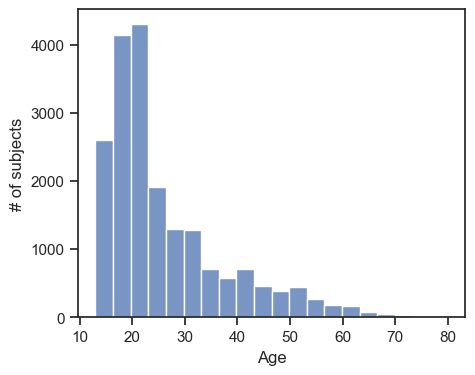

In [45]:
ax = sns.histplot(
    bigfive_human_data['age'],
    bins=20,
    binrange=(13, 80),
)
ax.set_xlabel('Age')
ax.set_ylabel('# of subjects')
plt.savefig('figures/demo-bigfive-age.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Model Data

In [ ]:
### independent 30 instances
records_gpt4 = json.load(open('records/bigfive_gpt4_2023_06_26-01_37_11_PM.json', 'r'))
records_turbo = json.load(open('records/bigfive_turbo_2023_06_26-02_06_26_AM.json', 'r'))


In [ ]:
bigfive_model_data = {}
bigfive_model_data['gpt4'] = pd.DataFrame(records_gpt4['choices'])
bigfive_model_data['turbo'] = pd.DataFrame(records_turbo['choices'])
bigfive_model_data['gpt4']['hue'] = 'ChatGPT-4'
bigfive_model_data['turbo']['hue'] = 'ChatGPT-3'

In [ ]:
questions = {}
with open('data/bigfive.tsv', 'r') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        questions[row[0]] = row[1]

keyed = {}
indices = defaultdict(int)
dimensions = 'EACNO'
with open('data/bigfive_IPIP.tsv', 'r') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        d = dimensions[int(row[-1][1])-1]
        v = row[-1][2]
        indices[d] += 1
        k = '%s%i' % (d, indices[d])
        keyed[k] = v

In [ ]:
models = ['gpt4', 'turbo']
beg_pos = list(range(7, 100, 10))[:5]
# d_scores_model = defaultdict(dict)

dimensions = 'ENACO'
for i, d in enumerate(dimensions):
    
    ### human scores
    d_score = 0
    for j in range(10):
        k = '%s%i' % (d, j+1)
        v = keyed[k]
        score = bigfive_human_data.iloc[:, beg_pos[i]+j]
        if v == '-': score = 6 - score
        d_score += score
    bigfive_human_data[d] = d_score

    ### model scores
    for model in models:
        d_score = 0
        records = eval('records_%s' % model)
        for j in range(10):
            k = '%s%i' % (d, j+1)
            v = keyed[k]
            score = bigfive_model_data[model].iloc[:, i*10+j]
            # score = np.mean(records['choices'][k])
            if v == '-': score = 6 - score
            d_score += score
        # d_scores_model[model][d] = d_score
        bigfive_model_data[model][d] = d_score

In [ ]:
data = pd.concat([
    bigfive_human_data, 
    bigfive_model_data['gpt4'], 
    bigfive_model_data['turbo']
], ignore_index=True)
data[['E', 'hue']]
data['N'] = 60 - data['N']
data[[*dimensions, 'hue']]

,E,N,A,C,O,hue
0,44,11,46,47,43,Human
1,22,31,35,42,26,Human
2,35,46,38,49,45,Human
3,22,43,37,26,41,Human
4,34,30,44,34,34,Human
...,...,...,...,...,...,...
19774,30,30,30,33,28,ChatGPT-3
19775,30,30,32,32,28,ChatGPT-3
19776,31,30,30,33,29,ChatGPT-3
19777,30,30,32,33,28,ChatGPT-3


In [ ]:
from scipy.stats import percentileofscore

for d in dimensions:
    median_gpt4 = np.median(data[data['hue'] == 'ChatGPT-4'][d])
    median_turbo = np.median(data[data['hue'] == 'ChatGPT-3'][d])
    print(d, median_gpt4, median_turbo)
    human_data = data[data['hue'] == 'Human'][d]
    print('gpt4', percentileofscore(human_data, median_gpt4))
    print('turbo', percentileofscore(human_data, median_turbo))

E 31.0 30.0
gpt4 53.35209696232061
turbo 49.35087986206197
N 29.0 30.0
gpt4 41.27491252091892
turbo 45.41812465135149
A 36.0 32.0
gpt4 32.38754500735332
turbo 17.237182412901266
C 36.0 33.0
gpt4 62.695877072873884
turbo 47.101780009128255
O 37.5 28.0
gpt4 37.943100562908874
turbo 4.962219179471576


### Plot

[30. 31. 39. 34. 40.] [18.44638655 17.23521204 14.29168605 14.613021   12.5134136 ]
[31.  29.  36.  36.  37.5] [1.855715   1.45586408 2.0068847  1.42876846 1.87420481]
[30. 30. 32. 33. 28.] [1.94640842 0.         2.4597916  2.01602773 1.46059349]


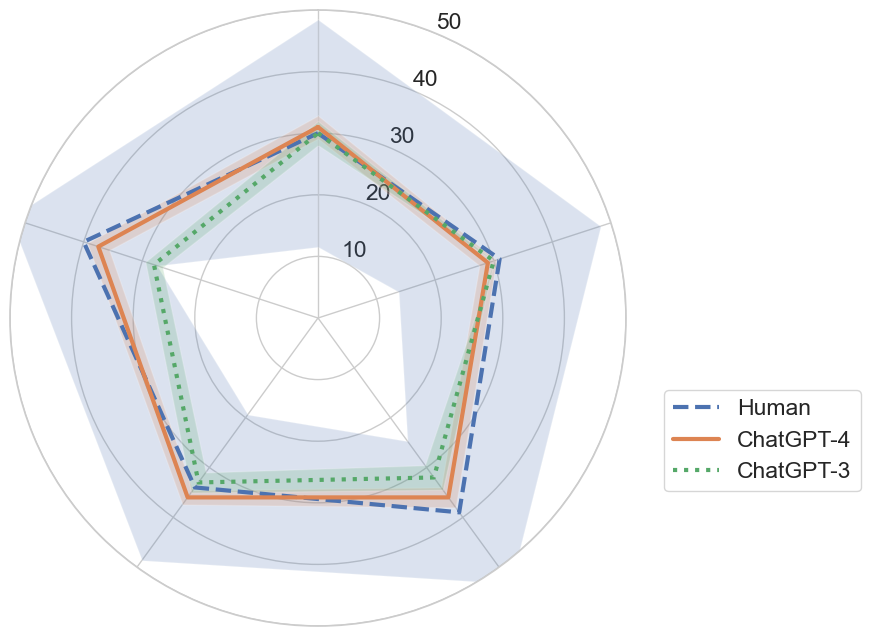

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

categories=['Extraversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
categories=[*dimensions]
categories = [''] * len(dimensions)
N = len(categories)
value_type = 'median'
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

hues = ['Human', 'ChatGPT-4', 'ChatGPT-3']
hue2line = {
    'Human': '--',
    'ChatGPT-4': '-',
    'ChatGPT-3': ':',
}
for hue in hues:
    d_scores = data[data['hue'] == hue][[*dimensions]].agg(['median', 'mean', 'std'])
    values = np.array(d_scores.loc[value_type])
    errors = np.array(d_scores.loc['std']) * 2
    print(values, errors)
    values = np.concatenate((values, [values[0]]))  # Close the plot
    errors = np.concatenate((errors, [errors[0]]))  # Close the plot

    ax.fill_between(angles, values - errors, values + errors, alpha=0.2)
    ax.plot(angles, values, linestyle=hue2line[hue], linewidth=3, label=hue)
 
plt.xticks(angles[:-1], categories)
# ax.set_rlabel_position(0)
plt.ylim(0,50)
plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0.2))
# plt.savefig('figures/cmp-bigfive.pdf', format='pdf', bbox_inches='tight')
plt.show()


## Fig. 2: Turing Test

Results may vary due to randomness in the simulation.

In [ ]:
def simulate_Turing(samples_0, samples_1, n_bin=10, lim_a=0, lim_b=100, n_draw=100000):
    hist_0 = np.histogram(samples_0, bins=n_bin, range=(lim_a, lim_b))[0] / len(samples_0)
    n_wins = 0
    n_ties = 0
    for _ in tqdm(range(n_draw)):
        try:
            sample_0 = np.random.choice(samples_0)
            sample_1 = np.random.choice(samples_1)
            idx_0 = min(math.floor((sample_0 - lim_a) / (lim_b - lim_a) * n_bin), n_bin-1)
            idx_1 = min(math.floor((sample_1 - lim_a) / (lim_b - lim_a) * n_bin), n_bin-1)
            if hist_0[idx_1] > hist_0[idx_0]:
                n_wins += 1
            elif hist_0[idx_1] == hist_0[idx_0]:
                n_ties += 1
        except:
            continue
    return n_wins / n_draw, n_ties / n_draw, (n_draw - n_wins - n_ties) / n_draw

In [ ]:
print('human', simulate_Turing(df_dictator_human['choices'], df_dictator_human['choices']))
print('gpt4', simulate_Turing(df_dictator_human['choices'], df_dictator_gpt4['choices']))
print('turbo', simulate_Turing(df_dictator_human['choices'], df_dictator_turbo['choices']))

NameError: name 'df_dictator_human' is not defined

In [ ]:
print('human', simulate_Turing(df_ultimatum_1_human['choices'], df_ultimatum_1_human['choices']))
print('gpt4', simulate_Turing(df_ultimatum_1_human['choices'], df_ultimatum_1_gpt4['choices']))
print('turbo', simulate_Turing(df_ultimatum_1_human['choices'], df_ultimatum_1_turbo['choices']))

In [ ]:
print('human', simulate_Turing(df_ultimatum_2_human['choices'], df_ultimatum_2_human['choices']))
print('gpt4', simulate_Turing(df_ultimatum_2_human['choices'], df_ultimatum_2_gpt4['choices']))
print('turbo', simulate_Turing(df_ultimatum_2_human['choices'], df_ultimatum_2_turbo['choices']))

In [ ]:
print('human', simulate_Turing(df_trust_1_human['choices'], df_trust_1_human['choices']))
print('gpt4', simulate_Turing(df_trust_1_human['choices'], df_trust_1_gpt4['choices']))
print('turbo', simulate_Turing(df_trust_1_human['choices'], df_trust_1_turbo['choices']))

In [ ]:
print('human', simulate_Turing(df_trust_3_human['choices'], df_trust_3_human['choices'], lim_b=150))
print('gpt4', simulate_Turing(df_trust_3_human['choices'], df_trust_3_gpt4['choices'], lim_b=150))
print('turbo', simulate_Turing(df_trust_3_human['choices'], df_trust_3_turbo['choices'], lim_b=150))

In [ ]:
print('human', simulate_Turing(df_PG_human['choices'], df_PG_human['choices'], lim_b=20))
print('gpt4', simulate_Turing(df_PG_human['choices'], df_PG_gpt4['choices'], lim_b=20))
print('gpt4', simulate_Turing(df_PG_turbo['choices'], df_PG_turbo['choices'], lim_b=20))

In [ ]:
print('human', simulate_Turing(prefix_to_choices_human[''], prefix_to_choices_human['']))
print('gpt4', simulate_Turing(prefix_to_choices_human[''],prefix_to_choices_model['ChatGPT-4']['']))
print('turbo', simulate_Turing(prefix_to_choices_human[''], prefix_to_choices_model['ChatGPT-3']['']))

In [ ]:
print('human', r_coo_human * r_def_human, r_coo_human * r_coo_human + r_def_human * r_def_human, r_def_human * r_coo_human)
print('gpt4', r_coo_human * r_def_gpt4, r_coo_human * r_coo_gpt4 + r_def_human * r_def_gpt4, r_def_human * r_coo_gpt4)
print('turbo', r_coo_human * r_def_turbo, r_coo_human * r_coo_turbo + r_def_human * r_def_turbo, r_def_human * r_coo_turbo)

## Fig. 3: Distributions

### Dictator Game

#### Human Data

In [ ]:
binrange = (0, 100)
moves = []
with open('data/dictator.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    col2idx = {col: idx for idx, col in enumerate(header)}
    for row in reader:
        record = {col: row[idx] for col, idx in col2idx.items()}

        if record['Role'] != 'first': continue
        if int(record['Round']) > 1: continue
        if int(record['Total']) != 100: continue
        if record['move'] == 'None': continue
        if record['gameType'] != 'dictator': continue

        move = float(record['move'])
        if move < binrange[0] or \
            move > binrange[1]: continue
        
        moves.append(move)

df_dictator_human = choices_to_df(moves, 'Human')

#### Model Data

In [ ]:
choices = [50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
df_dictator_gpt4 = choices_to_df(choices, hue=str('ChatGPT-4'))

choices = [25, 35, 70, 30, 20, 25, 40, 80, 30, 30, 40, 30, 30, 30, 30, 30, 40, 40, 30, 30, 40, 30, 60, 20, 40, 25, 30, 30, 30]
df_dictator_turbo = choices_to_df(choices, hue=str('ChatGPT-3'))

In [ ]:
print(len(df_dictator_gpt4.dropna()))
print(len(df_dictator_turbo.dropna()))

30
29


In [ ]:
records = json.load(open('records/dictator_wo_ex_2023_03_13-11_24_07_PM.json', 'r'))
choices = extract_choices(records)
print(', '.join([str(x) for x in choices]))

Invalid answer: Sure, here's my choice: 

I would divide the money as follows: 
- I would give [$35] to the other player.
- I would keep [$65] for myself. 

This way, the other player still gets a significant amount of money, but I also keep a majority of it.
Invalid answer: Sure, here's how I would divide the $100: 

I would keep [$30] for myself and give the other player [$70].
Invalid answer: Here's one way to divide the $100: 

I will give [$30] to the other player and keep the remaining [$70].
Invalid answer: Sure, here's one way to divide the money:

I would give the other player [$25] and keep [$75] for myself.
Invalid answer: Sure! Here's my choice: 

I would divide the money with $80 for the other player [$80] and $20 for myself [$20]. I believe this is a fair division as the other player will receive a significant amount of money, while I will still receive a portion for my participation.
Invalid answer: Sure! Here's one possible way to divide the money: 

You can keep [$70],

In [ ]:
# for df_dictator_gpt4
print('df_dictator_gpt4:')
print('min:', df_dictator_gpt4['choices'].min())
print('max:', df_dictator_gpt4['choices'].max())
print('mean:', df_dictator_gpt4['choices'].mean())
print('std:', df_dictator_gpt4['choices'].std())

# for df_dictator_turbo
print('df_dictator_turbo:')
print('min:', df_dictator_turbo['choices'].min())
print('max:', df_dictator_turbo['choices'].max())
print('mean:', df_dictator_turbo['choices'].mean())
print('std:', df_dictator_turbo['choices'].std())


df_dictator_gpt4:
min: 50.0
max: 50.0
mean: 50.0
std: 0.0
df_dictator_turbo:
min: 20
max: 80
mean: 35.172413793103445
std: 13.527931331448071


#### Plot

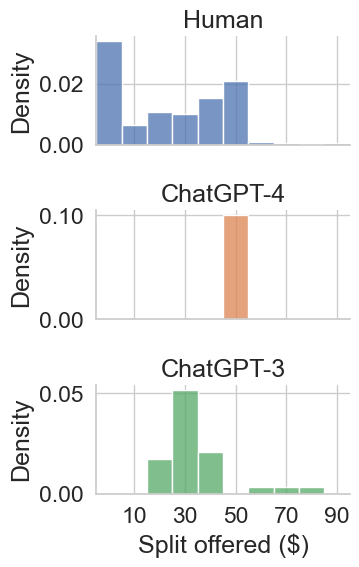

In [ ]:
plot_facet(
    df_list=[
        df_dictator_human, 
        df_dictator_gpt4, 
        df_dictator_turbo
    ],
    binrange=(0, 100),
    stat='density',
    x_label='Split offered ($)',
    kde=False,
)
# plt.savefig('figures/cmp-dictator.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Ultimatum Game

#### Human Data

In [ ]:
df = pd.read_csv('data/ultimatum_strategy.csv')
df = df[df['gameType'] == 'ultimatum_strategy']
df = df[df['Role'] == 'player']
df = df[df['Round'] == 1]
df = df[df['Total'] == 100]
df = df[df['move'] != 'None']
df['propose'] = df['move'].apply(lambda x: eval(x)[0])
df['accept'] = df['move'].apply(lambda x: eval(x)[1])
df = df[(df['propose'] >= 0) & (df['propose'] <= 100)]
df = df[(df['accept'] >= 0) & (df['accept'] <= 100)]
# df.head()

In [ ]:
df_ultimatum_1_human = choices_to_df(list(df['propose']), 'Human')
df_ultimatum_2_human = choices_to_df(list(df['accept']), 'Human')

#### Model Data

In [ ]:
choices = [50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
df_ultimatum_1_gpt4 = choices_to_df(choices, hue=str('ChatGPT-4'))

choices = [40, 40, 40, 30, 70, 70, 50, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 30, 30, 35, 50, 40, 70, 40, 60, 60, 70, 40, 50]
df_ultimatum_1_turbo = choices_to_df(choices, hue=str('ChatGPT-3'))

choices = [50.0, 50.0, 50.0, 1.0, 1.0, 1.0, 50.0, 25.0, 50.0, 1.0, 1.0, 20.0, 50.0, 50.0, 50.0, 20.0, 50.0, 1.0, 1.0, 1.0, 50.0, 50.0, 50.0, 1.0, 1.0, 1.0, 20.0, 1.0] + [0, 1]
df_ultimatum_2_gpt4 = choices_to_df(choices, hue=str('ChatGPT-4'))

choices = [None, 50, 50, 50, 50, 30, None, None, 30, 33.33, 40, None, 50, 40, None, 1, 30, None, 10, 50, 30, 10, 30, None, 30, None, 10, 30, 30, 30]
df_ultimatum_2_turbo = choices_to_df(choices, hue=str('ChatGPT-3'))

In [ ]:
print(len(df_ultimatum_1_gpt4.dropna()))
print(len(df_ultimatum_1_turbo.dropna()))

print(len(df_ultimatum_2_gpt4.dropna()))
print(len(df_ultimatum_2_turbo.dropna()))

30
30
30
22


In [ ]:
# min max mean std
# for df_ultimatum_1_gpt4
print('df_ultimatum_1_gpt4:')
print('min:', df_ultimatum_1_gpt4['choices'].min())
print('max:', df_ultimatum_1_gpt4['choices'].max())
print('mean:', df_ultimatum_1_gpt4['choices'].mean())
print('std:', df_ultimatum_1_gpt4['choices'].std())

# for df_ultimatum_1_turbo
print('df_ultimatum_1_turbo:')
print('min:', df_ultimatum_1_turbo['choices'].min())
print('max:', df_ultimatum_1_turbo['choices'].max())
print('mean:', df_ultimatum_1_turbo['choices'].mean())
print('std:', df_ultimatum_1_turbo['choices'].std())

df_ultimatum_1_gpt4:
min: 50.0
max: 50.0
mean: 50.0
std: 0.0
df_ultimatum_1_turbo:
min: 30
max: 70
mean: 45.166666666666664
std: 12.069006568074684


In [ ]:
choices = [50.0, 50.0, 10.0, 40.0, 20.0, 50.0, 1.0, 1.0, 50.0, 1.0, 50.0, 50.0, 20.0, 10.0, 50.0, 20.0, 1.0, 1.0, 50.0, 1.0, 20.0, 1.0, 50.0, 50.0, 20.0, 20.0, 50.0, 20.0, 1.0, 50.0]
df_ultimatum_2_gpt4_female = choices_to_df(choices, hue='ChatGPT-4 Female')

choices = [1.0, 1.0, 1.0, 20.0, 1.0, 1.0, 50.0, 1.0, 1.0, 50.0, 50.0, 50.0, 20.0, 20.0, 1.0, 50.0, 1.0, 1.0, 1.0, 50.0, 20.0, 1.0, 50.0, 20.0, 20.0, 10.0, 50.0, 1.0, 1.0, 1.0]
df_ultimatum_2_gpt4_male = choices_to_df(choices, hue='ChatGPT-4 Male')

choices = [40.0, 1.0, 1.0, 20.0, 1.0, 20.0, 50.0, 50.0, 1.0, 1.0, 1.0, 50.0, 1.0, 20.0, 50.0, 10.0, 50.0, 1.0, 1.0, 20.0, 1.0, 50.0, 20.0, 20.0, 20.0, 1.0, 1.0, 1.0, 1.0, 40.0]
df_ultimatum_2_gpt4_US = choices_to_df(choices, hue='ChatGPT-4 US')

choices = [1.0, 1.0, 20.0, 50.0, 1.0, 1.0, 1.0, 1.0, 20.0, 20.0, 50.0, 20.0, 20.0, 50.0, 20.0, 1.0, 40.0, 50.0, 1.0, 1.0, 1.0, 20.0, 1.0, 1.0, 50.0, 50.0, 1.0, 1.0, 1.0, 1.0]
df_ultimatum_2_gpt4_Poland = choices_to_df(choices, hue='ChatGPT-4 Poland')

choices = [50.0, 1.0, 20.0, 50.0, 50.0, 50.0, 50.0, 1.0, 1.0, 50.0, 1.0, 50.0, 1.0, 50.0, 1.0, 20.0, 1.0, 1.0, 20.0, 50.0, 0.0, 20.0, 1.0, 1.0, 1.0, 1.0, 20.0, 20.0, 50.0, 20.0]
df_ultimatum_2_gpt4_China = choices_to_df(choices, hue='ChatGPT-4 China')

choices = [1.0, 1.0, 1.0, 50.0, 1.0, 1.0, 50.0, 40.0, 1.0, 1.0, 1.0, 1.0, 20.0, 1.0, 1.0, 50.0, 1.0, 50.0, 1.0, 20.0, 1.0, 20.0, 1.0, 50.0, 1.0, 50.0, 20.0, 1.0, 1.0, 50.0]
df_ultimatum_2_gpt4_UK = choices_to_df(choices, hue='ChatGPT-4 UK')

choices = [50.0, 1.0, 20.0, 50.0, 50.0, 50.0, 50.0, 10.0, 1.0, 40.0, 50.0, 20.0, 1.0, 1.0, 1.0, 50.0, 50.0, 20.0, 20.0, 1.0, 1.0, 50.0, 20.0, 50.0, 50.0, 20.0, 1.0, 20.0, 50.0, 1]
df_ultimatum_2_gpt4_Columbia = choices_to_df(choices, hue='ChatGPT-4 Columbia')

choices = [50.0, 1.0, 50.0, 20.0, 20.0, 20.0, 50.0, 20.0, 20.0, 1.0, 1.0, 1.0, 1.0, 20.0, 1.0, 50.0, 1.0, 20.0, 20.0, 50.0, 1.0, 50.0, 1.0, 40.0, 1.0, 20.0, 1.0, 20.0, 1.0, 1.0]
df_ultimatum_2_gpt4_under = choices_to_df(choices, hue='ChatGPT-4 Undergrad')

choices = [1.0, 20.0, 1.0, 40.0, 50.0, 1.0, 1.0, 1.0, 25.0, 20.0, 50.0, 20.0, 50.0, 50.0, 1.0, 50.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50.0, 20.0, 1.0, 1.0, 1.0, 50.0, 20.0, 20.0]
df_ultimatum_2_gpt4_grad = choices_to_df(choices, hue='ChatGPT-4 Graduate')

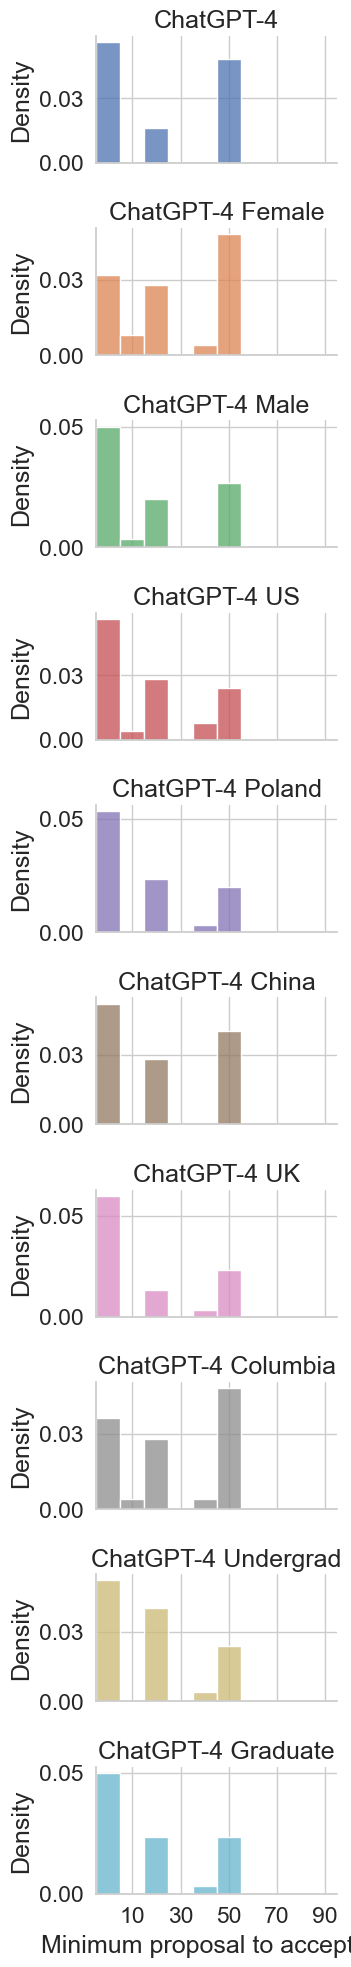

In [ ]:
plot_facet(
    df_list=[
        df_ultimatum_2_gpt4,
        df_ultimatum_2_gpt4_female,
        df_ultimatum_2_gpt4_male,
        df_ultimatum_2_gpt4_US,
        df_ultimatum_2_gpt4_Poland,
        df_ultimatum_2_gpt4_China,
        df_ultimatum_2_gpt4_UK,
        df_ultimatum_2_gpt4_Columbia,
        df_ultimatum_2_gpt4_under,
        df_ultimatum_2_gpt4_grad,
    ],
    binrange=(0, 100),
    # binwidth=10,
    stat='density',
    x_label='Minimum proposal to accept ($)',
)
# plt.savefig('figures/cmp-ultimatum-respond-demo.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### Plot

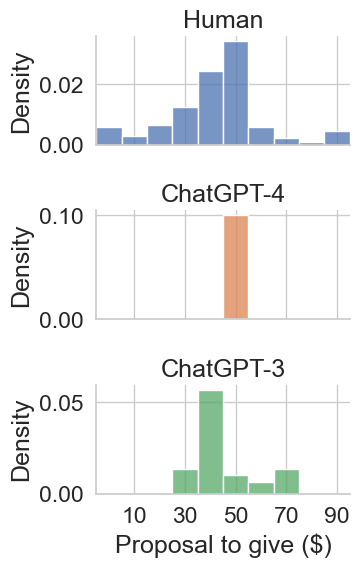

In [ ]:
plot_facet(
    df_list=[
        df_ultimatum_1_human,
        df_ultimatum_1_gpt4,
        df_ultimatum_1_turbo,
    ],
    binrange=(0, 100),
    # binwidth=10,
    stat='density',
    x_label='Proposal to give ($)',
)
# plt.savefig('figures/cmp-ultimatum-proposal.pdf', format='pdf', bbox_inches='tight')
plt.show()

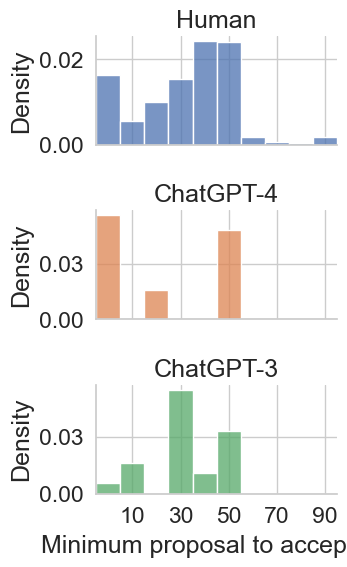

In [ ]:
plot_facet(
    df_list=[
        df_ultimatum_2_human,
        df_ultimatum_2_gpt4,
        df_ultimatum_2_turbo,
    ],
    binrange=(0, 100),
    # binwidth=10,
    stat='density',
    x_label='Minimum proposal to accept ($)',
)
# plt.savefig('figures/cmp-ultimatum-respond.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### Reproducibility

In [ ]:
choices = [50.0, 50.0, 50.0, 1.0, 1.0, 1.0, 50.0, 25.0, 50.0, 1.0, 1.0, 20.0, 50.0, 50.0, 50.0, 20.0, 50.0, 1.0, 1.0, 1.0, 50.0, 50.0, 50.0, 1.0, 1.0, 1.0, 20.0, 1.0] + [0, 1]
df_ultimatum_2_gpt4 = choices_to_df(choices, hue=str('ChatGPT-4 (0314, 04.05)'))

records = json.load(open('records/ultimatum_2_gpt4_2023_12_29-10_42_42_PM.json', 'r'))
choices = extract_choices(records)
df_ultimatum_2_gpt4_1229 = choices_to_df(choices, hue=str('ChatGPT-4 (0314, 12.29)'))

records = json.load(open('records/ultimatum_2_gpt4_1106_2023_12_29-11_15_35_PM.json', 'r'))
choices = extract_choices(records)
df_ultimatum_2_gpt4_1106_1229 = choices_to_df(choices, hue=str('ChatGPT-4 (1106, 12.29)'))

plot_facet(
    df_list=[
        df_ultimatum_2_gpt4,
        df_ultimatum_2_gpt4_1229,
        df_ultimatum_2_gpt4_1106_1229,
    ],
    binrange=(0, 100),
    # binwidth=10,
    stat='density',
    x_label='Minimum proposal to accept ($)',
)
plt.savefig('figures/repro-ultimatum-respond.pdf', format='pdf', bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'records/ultimatum_2_gpt4_2023_12_29-10_42_42_PM.json'

In [37]:
choices = [None, 50, 50, 50, 50, 30, None, None, 30, 33.33, 40, None, 50, 40, None, 1, 30, None, 10, 50, 30, 10, 30, None, 30, None, 10, 30, 30, 30]
df_ultimatum_2_turbo = choices_to_df(choices, hue=str('ChatGPT-3 (0301, 03.13)'))

records = json.load(open('records/ultimatum_2_turbo_2023_12_29-10_43_41_PM.json', 'r'))
choices = extract_choices(records)
df_ultimatum_2_turbo_1229 = choices_to_df(choices, hue=str('ChatGPT-3 (0301, 12.29)'))

records = json.load(open('records/ultimatum_2_turbo_1106_2023_12_29-11_57_30_PM.json', 'r'))
choices = extract_choices(records)
df_ultimatum_2_turbo_1106_1229 = choices_to_df(choices, hue=str('ChatGPT-3 (1106, 12.29)'))

plot_facet(
    df_list=[
        df_ultimatum_2_turbo,
        df_ultimatum_2_turbo_1229,
        df_ultimatum_2_turbo_1106_1229,
    ],
    binrange=(0, 100),
    # binwidth=10,
    stat='density',
    x_label='Minimum proposal to accept ($)',
)
# plt.savefig('figures/cmp-ultimatum-respond.pdf', format='pdf', bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'records/ultimatum_2_turbo_2023_12_29-10_43_41_PM.json'

### Trust Game

#### Human Data

In [ ]:
binrange = (0, 100)
moves_1 = []
moves_2 = defaultdict(list)
with open('data/trust_investment.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    col2idx = {col: idx for idx, col in enumerate(header)}
    for row in reader:
        record = {col: row[idx] for col, idx in col2idx.items()}

        # if record['Role'] != 'first': continue
        if int(record['Round']) > 1: continue
        # if int(record['Total']) != 100: continue
        if record['move'] == 'None': continue
        if record['gameType'] != 'trust_investment': continue

        if record['Role'] == 'first':
            move = float(record['move'])
            if move < binrange[0] or \
                move > binrange[1]: continue
            moves_1.append(move)
        elif record['Role'] == 'second':
            inv, ret = eval(record['roundResult'])
            if ret < 0 or \
                ret > inv * 3: continue
            moves_2[inv].append(ret)
        else: continue

df_trust_1_human = choices_to_df(moves_1, 'Human')
df_trust_2_human = choices_to_df(moves_2[10], 'Human')
df_trust_3_human = choices_to_df(moves_2[50], 'Human')
df_trust_4_human = choices_to_df(moves_2[100], 'Human')

#### Model Data

In [ ]:
choices = [50.0, 50.0, 40.0, 30.0, 50.0, 50.0, 40.0, 50.0, 50.0, 50.0, 50.0, 50.0, 30.0, 30.0, 50.0, 50.0, 50.0, 40.0, 40.0, 50.0, 50.0, 50.0, 50.0, 40.0, 50.0, 50.0, 50.0, 50.0] 
df_trust_1_gpt4 = choices_to_df(choices, hue=str('ChatGPT-4'))

choices = [50.0, 50.0, 30.0, 30.0, 30.0, 60.0, 50.0, 40.0, 20.0, 20.0, 50.0, 40.0, 30.0, 20.0, 30.0, 20.0, 30.0, 60.0, 50.0, 30.0, 50.0, 20.0, 20.0, 30.0, 50.0, 30.0, 30.0, 50.0, 40.0] + [30]
df_trust_1_turbo = choices_to_df(choices, hue=str('ChatGPT-3'))

choices = [20.0, 20.0, 20.0, 20.0, 15.0, 15.0, 15.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 15.0, 20.0, 20.0, 20.0, 20.0, 20.0, 15.0, 15.0, 20.0, 15.0, 15.0, 15.0, 15.0, 15.0, 20.0, 20.0, 15.0]
df_trust_2_gpt4 = choices_to_df(choices, hue=str('ChatGPT-4'))

choices = [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 15.0, 25.0, 30.0, 30.0, 20.0, 25.0, 30.0, 20.0, 20.0, 18.0] + [20, 20, 20, 25, 25, 25, 30]
df_trust_2_turbo = choices_to_df(choices, hue=str('ChatGPT-3'))

choices = [100.0, 75.0, 75.0, 75.0, 75.0, 75.0, 100.0, 75.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 75.0, 100.0, 75.0, 75.0, 75.0, 100.0, 100.0, 100.0, 75.0, 100.0, 100.0, 100.0, 100.0, 75.0, 100.0, 75.0]
df_trust_3_gpt4 = choices_to_df(choices, hue=str('ChatGPT-4'))

choices = [150.0, 100.0, 150.0, 150.0, 50.0, 150.0, 100.0, 150.0, 100.0, 100.0, 100.0, 150.0] + [100, 100, 100, 100, 100, 100, 100, 100]
df_trust_3_turbo = choices_to_df(choices, hue=str('ChatGPT-3'))

choices = [200.0, 200.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 200.0, 200.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0]
df_trust_4_gpt4 = choices_to_df(choices, hue=str('ChatGPT-4'))

choices = [225.0, 225.0, 300.0, 300.0, 220.0, 300.0, 250.0] + [200, 200, 250, 200, 200]
df_trust_4_turbo = choices_to_df(choices, hue=str('ChatGPT-3'))

In [ ]:
print(len(df_trust_1_gpt4.dropna()))
print(len(df_trust_1_turbo.dropna()))

print(len(df_trust_2_gpt4.dropna()))
print(len(df_trust_2_turbo.dropna()))

print(len(df_trust_3_gpt4.dropna()))
print(len(df_trust_3_turbo.dropna()))

print(len(df_trust_4_gpt4.dropna()))
print(len(df_trust_4_turbo.dropna()))

In [ ]:
records = json.load(open('records/trust_2_gpt4_2023_04_07-11_46_45_PM.json', 'r'))
choices = extract_choices(records)
print(', '.join([str(c) for c in choices]))

In [ ]:
records = json.load(open('records/trust_4_gpt4_2023_04_08-12_24_56_AM.json', 'r'))
choices = extract_choices(records)
print(', '.join([str(c) for c in choices]))

In [ ]:
# min max mean std of df_trust_1_turbo
print('df_trust_1_turbo:')
print('min:', df_trust_1_turbo['choices'].min())
print('max:', df_trust_1_turbo['choices'].max())
print('mean:', df_trust_1_turbo['choices'].mean())
print('std:', df_trust_1_turbo['choices'].std())


In [ ]:
# min max mean std of df_trust_1_gpt4
print('df_trust_1_gpt4:')
print('min:', df_trust_1_gpt4['choices'].min())
print('max:', df_trust_1_gpt4['choices'].max())
print('mean:', df_trust_1_gpt4['choices'].mean())
print('std:', df_trust_1_gpt4['choices'].std())

In [ ]:
# min max mean std of df_trust_4_turbo
print('df_trust_4_turbo:')
print('min:', df_trust_4_turbo['choices'].min())
print('max:', df_trust_4_turbo['choices'].max())
print('mean:', df_trust_4_turbo['choices'].mean())
print('std:', df_trust_4_turbo['choices'].std())

#### Plot

In [ ]:
plot_facet(
    df_list=[
        df_trust_1_human,
        df_trust_1_gpt4,
        df_trust_1_turbo,
    ],
    binrange=(0, 100),
    # binwidth=10,
    stat='density',
    x_label='Investment ($)',
)
# plt.savefig('figures/cmp-trust-invest.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
plot_facet(
    df_list=[
        df_trust_3_human,
        df_trust_3_gpt4,
        df_trust_3_turbo,
    ],
    binrange=(0, 150),
    bins=15,
    # binwidth=10,
    stat='density',
    x_label='Return to investor ($)',
    xticks_locs=[0, 25, 50, 75, 100, 125, 150],
)
# plt.savefig('figures/cmp-trust-return.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Public Goods

#### Human Data

In [ ]:
df = pd.read_csv('data/public_goods_linear_water.csv')
df = df[df['Role'] == 'contributor']
df = df[df['Round'] <= 3]
df = df[df['Total'] == 20]
df = df[df['groupSize'] == 4]
df = df[df['move'] != None]
df = df[(df['move'] >= 0) & (df['move'] <= 20)]
df = df[df['gameType'] == 'public_goods_linear_water']

In [ ]:
round_1 = df[df['Round'] == 1]['move']
round_2 = df[df['Round'] == 2]['move']
round_3 = df[df['Round'] == 3]['move']
print(len(round_1), len(round_2), len(round_3))
df_PG_human = pd.DataFrame({
    'choices': list(round_1)
})
df_PG_human['hue'] = 'Human'
df_PG_human

##### Payoffs

#### Model Data

In [ ]:
file_names = [
    # 'records/PG_basic_turbo_2023_05_09-02_49_09_AM.json',
    # 'records/PG_basic_turbo_loss_2023_05_09-03_59_49_AM.json'
    'records/PG_basic_gpt4_2023_05_09-11_15_42_PM.json',
    'records/PG_basic_gpt4_loss_2023_05_09-10_44_38_PM.json',
]

choices = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        choices += json.load(f)['choices']
choices_baseline = choices

choices = [tuple(x)[0] for x in choices]
# df_PG_turbo = choices_to_df(choices, hue=str('ChatGPT-3'))
# df_PG_turbo.head()
df_PG_gpt4 = choices_to_df(choices, hue=str('ChatGPT-4'))
df_PG_gpt4.head()

In [ ]:
print(len(df_PG_gpt4.dropna()))
print(len(df_PG_turbo.dropna()))

#### Plot

In [ ]:
g = plot_facet(
    df_list=[
        df_PG_human, 
        df_PG_gpt4, 
        df_PG_turbo
    ],
    binrange=(0, 20),
    # binwidth=2,
    stat='density',
    x_label='Contribution ($)',
)
# g.set(ylim=(0, 0.5))
# plt.savefig('figures/cmp-PG.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Bomb Risk Game

1 safe, 0 bomb

#### Human Data

In [ ]:
df = pd.read_csv('data/bomb_risk.csv')
df = df[df['Role'] == 'player']
df = df[df['gameType'] == 'bomb_risk']
df.sort_values(by=['UserID', 'Round'])

prefix_to_choices_human = defaultdict(list)
prefix_to_IPW = defaultdict(list)
prev_user = None
prev_move = None
prefix = ''
bad_user = False
for _, row in df.iterrows():
    if bad_user: continue
    if row['UserID'] != prev_user:
        prev_user = row['UserID']
        prefix = ''
        bad_user = False

    move = row['move']
    if move < 0 or move > 100:
        bad_users = True
        continue
    prefix_to_choices_human[prefix].append(move)

    if len(prefix) == 0:
        prefix_to_IPW[prefix].append(1)
    elif prefix[-1] == '1':
        prev_move = min(prev_move, 98)
        prefix_to_IPW[prefix].append(1./(100 - prev_move))
    elif prefix[-1] == '0':
        prev_move = max(prev_move, 1)
        prefix_to_IPW[prefix].append(1./(prev_move))
    else: assert False
    
    prev_move = move

    prefix += '1' if row['roundResult'] == 'SAFE' else '0'

#### Model Data

In [ ]:
prefix_to_choices_model = defaultdict(lambda : defaultdict(list))
for model in ['ChatGPT-4', 'ChatGPT-3']:
    if model == 'ChatGPT-4':
        file_names = [
            'bomb_gpt4_2023_05_15-12_13_51_AM.json'
        ]
    elif model == 'ChatGPT-3':
        file_names = [
            'bomb_turbo_2023_05_14-10_45_50_PM.json'
        ]

    choices = []
    scenarios = []
    for file_name in file_names:
        with open(os.path.join('records', file_name), 'r') as f:
            records = json.load(f)
            choices += records['choices']
            scenarios += records['scenarios']

    assert len(scenarios) == len(choices)
    print('loaded %i valid records' % len(scenarios))

    prefix_to_choice = defaultdict(list)
    prefix_to_result = defaultdict(list)
    prefix_to_pattern = defaultdict(Counter)
    wrong_sum = 0
    for scenarios_tmp, choices_tmp in zip(scenarios, choices):

        result = 0
        for i, scenario in enumerate(scenarios_tmp):
            prefix = tuple(scenarios_tmp[:i])
            prefix = ''.join([str(x) for x in prefix])
            choice = choices_tmp[i]
            
            prefix_to_choice[prefix].append(choice)
            prefix_to_pattern[prefix][tuple(choices_tmp[:-1])] += 1

            prefix = tuple(scenarios_tmp[:i+1])
            if scenario == 1:
                result += choice
            prefix_to_result[prefix].append(result)

    print('# of wrong sum:', wrong_sum)
    print('# of correct sum:', len(scenarios) - wrong_sum)

    prefix_to_choices_model[model] = prefix_to_choice

#### Plot

In [ ]:
prefix = ''
df_bomb_human = choices_to_df(prefix_to_choices_human[prefix], hue='Human')
df_bomb_human['weight'] = prefix_to_IPW[prefix]
df_bomb_models = pd.concat([choices_to_df(
        prefix_to_choices_model[model][prefix], hue=model
    ) for model in prefix_to_choices_model]
)
df_bomb_models['weight'] = 1
g = plot_facet(
    df_list=[
        df_bomb_human,
        df_bomb_models,
    ],
    binrange=(0, 100),
    # binwidth=10,
    stat='density',
    # x_label='# of boxes to open ({})'.format(prefix),
    x_label='# of boxes opened',
    weights='weight',
)
# g.set(ylim=(0, 0.1))
# plt.savefig(f'figures/cmp-bomb-{prefix}.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Prisoner Dilemma

#### Human Data

In [ ]:
df = pd.read_csv('data/push_pull.csv')
df = df[df['gameType'] == 'push_pull']
df = df[df['Role'] == 'player']
df = df[(df['move'] == 0) | (df['move'] == 1)]
# df = df[df['Round'] <= 2]
df = df[df['groupSize'] == 2]

counter = -1
playIDs = []
otherMoves = []
for i, row in df.iterrows():
    if row['Round'] == 1:
        counter += 1
    playIDs.append(counter)
    roundResult = eval(row['roundResult'])
    roundResult.remove(row['move'])
    otherMoves.append(roundResult[0])
df['playID'] = playIDs
df['otherMove'] = otherMoves

In [ ]:
### first round

df[df['Round'] == 1]['move'].value_counts()

In [ ]:
n_coo_human = 36269
n_def_human = 44114
r_coo_human = n_coo_human / (n_coo_human + n_def_human)
r_def_human = n_def_human / (n_coo_human + n_def_human)
print(r_coo_human, r_def_human)

In [ ]:
### two rounds

playIDs_push = df[(
    df['Round'] == 1) & (
    df['otherMove'] == 0)]['playID'].unique()
playIDs_pull = df[(
    df['Round'] == 1) & (
    df['otherMove'] == 1)]['playID'].unique()

df_push = df[df['playID'].isin(playIDs_push)]
df_pull = df[df['playID'].isin(playIDs_pull)]

counter = Counter()
for playID in tqdm(playIDs_pull):
    df_tmp = df[df['playID'] == playID]
    try:
        move_1 = df_tmp[df_tmp['Round'] == 1]['move'].values[0]
        move_2 = df_tmp[df_tmp['Round'] == 2]['move'].values[0]
        counter[(move_1, move_2)] += 1
    except:
        continue

In [ ]:
playIDs_five = set(df[(
    df['Round'] == 1) & (
    df['otherMove'] == 1)]['playID'].unique())
playIDs_five = set(df[(
    df['Round'] == 2) & (
    df['otherMove'] == 1)]['playID'].unique()).intersection(playIDs_five)
playIDs_five = set(df[(
    df['Round'] == 3) & (
    df['otherMove'] == 0)]['playID'].unique()).intersection(playIDs_five)
playIDs_five = set(df[(
    df['Round'] == 4) & (
    df['otherMove'] == 0)]['playID'].unique()).intersection(playIDs_five)
playIDs_five = set(df[(
    df['Round'] == 5)]['playID'].unique()).intersection(playIDs_five)

df_five = df[df['playID'].isin(playIDs_five)]
print(len(playIDs_five))

for i in range(1, 6):
    n_push = len(df_five[(
        df_five['Round'] == i) & (
        df_five['move'] == 0)])
    n_pull = len(df_five[(
        df_five['Round'] == i) & (
        df_five['move'] == 1)])
    print('Round %i: %.2f push' % (i, n_push / (n_pull + n_push)))

In [ ]:
print(counter)

#### Model Data

In [ ]:
# records = json.load(open('records/PD_gpt4_two_rounds_push_2023_05_10-10_04_33_PM.json', 'r'))
records = json.load(open('records/PD_turbo_two_rounds_push_2023_05_08-06_03_40_PM.json', 'r'))
# records = json.load(open('records/PD_gpt4_two_rounds_pull_2023_05_08-08_57_08_PM.json', 'r'))
# records = json.load(open('records/PD_turbo_two_rounds_pull_2023_05_08-09_23_13_PM.json', 'r'))
# records = json.load(open('records/PD_gpt4_five_rounds_pull_2023_05_11-05_17_36_PM.json', 'r'))
# records = json.load(open('records/PD_turbo_five_rounds_pull_2023_05_11-08_03_28_PM.json', 'r'))
# print(records['choices'])
for i in range(len(records['choices'][0])-1):
    choices = [tuple(x[i:i+2]) for x in records['choices']]
    print(sorted(Counter(choices).items(), key=lambda item: item[0], reverse=True))

In [ ]:
n_coo_gpt4 = 29 + 0 + 0 + 26
n_def_gpt4 = 0 + 1 + 1 + 3
n_coo_turbo = 21 + 3 + 7 + 15
n_def_turbo = 3 + 3 + 4 + 4
r_coo_gpt4 = n_coo_gpt4 / (n_coo_gpt4 + n_def_gpt4)
r_def_gpt4 = n_def_gpt4 / (n_coo_gpt4 + n_def_gpt4)
r_coo_turbo = n_coo_turbo / (n_coo_turbo + n_def_turbo)
r_def_turbo = n_def_turbo / (n_coo_turbo + n_def_turbo)
print(r_coo_gpt4, r_def_gpt4)
print(r_coo_turbo, r_def_turbo)

In [ ]:
file_names = [
    'records/PD_gpt4_two_rounds_push_2023_05_10-10_04_33_PM.json',
    'records/PD_gpt4_two_rounds_pull_2023_05_08-08_57_08_PM.json'
]

choices = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        choices += json.load(f)['choices']
choices_baseline = choices

choices = [tuple(x)[0] for x in choices]
df_PG_gpt4 = choices_to_df(choices, hue=str('ChatGPT-4'))
df_PG_gpt4.head()

In [ ]:
file_names = [
    'records/PD_turbo_two_rounds_push_2023_05_08-06_03_40_PM.json',
    'records/PD_turbo_two_rounds_pull_2023_05_08-09_23_13_PM.json',
]

choices = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        choices += json.load(f)['choices']
choices_baseline = choices

choices = [tuple(x)[0] for x in choices]
df_PG_turbo = choices_to_df(choices, hue=str('ChatGPT-3'))
df_PG_turbo.head()

#### Plot

In [ ]:
# importing libraries
import matplotlib.pyplot as plt
import seaborn

fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(aspect="equal"))
  
# declaring data
# data = [46.87, 100-46.87] # human
# data = [96.67+86.67, 200-96.67-86.67] # gpt4
data = [80+73.33, 200-80-73.33] # turbo
keys = ['Cooperate', 'Defect']
  
# define Seaborn color palette to use
palette_color = [green, red]
  
# plotting data on chart
wedges, texts, autotexts = ax.pie(
    data, 
    # labels=keys, 
    # labeldistance=0.2,
    # pctdistance=0.5,
    colors=palette_color, 
    textprops=dict(color="w"),
    # hatch=['+', 'o'], 
    autopct='%.2f%%',
    startangle=90
)

# ax.legend(
#     wedges, keys,
#     # title="Ingredients",
#     loc="upper center",
#     fontsize=18,
#     bbox_to_anchor=(0.5, 1.1, 0, 0)
# )
  
# displaying chart
plt.setp(texts, size=24, weight="bold")
plt.setp(autotexts, size=24, weight="bold")
plt.show()

## Fig. 6: Payoff

In [ ]:
r = 1.
def CES(b, S, P, r=r):
    S = np.array(S)
    P = np.array(P)
    b = np.array(b)
    return (
        b     * S**r + \
        (1.-b) * P**r
    )**(1./r)

### Games

#### Dictator

In [ ]:
def expected_payoff(propose):
    payoff_player = 100 - propose
    payoff_partner = propose
    payoff_total = 100
    return payoff_player, payoff_total, payoff_partner

payoff_player, payoff_total, payoff_partner = zip(*[
    expected_payoff(p) for p in range(0, 101)
])

def player_average(player, choices):
    # remove None and NaN in choices
    choices = [c for c in choices if c == c]
    print('player', 'partner', 'combined')
    payoff_player_mean = np.mean([payoff_player[int(c)] for c in choices])
    payoff_total_mean = np.mean([payoff_total[int(c)] for c in choices])
    payoff_partner_mean = np.mean([payoff_partner[int(c)] for c in choices])
    print(player, 'mean', payoff_player_mean, payoff_partner_mean, payoff_total_mean)
    payoff_player_std = np.std([payoff_player[int(c)] for c in choices])
    payoff_total_std = np.std([payoff_total[int(c)] for c in choices])
    payoff_partner_std = np.std([payoff_partner[int(c)] for c in choices])
    print(player, 'std', payoff_player_std, payoff_partner_std, payoff_total_std)
    payoff_player_samples = [payoff_player[int(c)] for c in choices]
    payoff_partner_samples = [payoff_partner[int(c)] for c in choices]
    payoff_player_se = np.std([payoff_player[int(c)] for c in choices]) / np.sqrt(len(choices))
    payoff_total_se = np.std([payoff_total[int(c)] for c in choices]) / np.sqrt(len(choices))
    payoff_partner_se = np.std([payoff_partner[int(c)] for c in choices]) / np.sqrt(len(choices))
    print(player, 'se', payoff_player_se, payoff_partner_se, payoff_total_se)
    return payoff_player_samples, payoff_partner_samples
payoff_player_samples_dictator_human, payoff_partner_samples_dictator_human = player_average('human', df_dictator_human['choices'])
payoff_player_samples_dictator_gpt4, payoff_partner_samples_dictator_gpt4 = player_average('gpt4', df_dictator_gpt4['choices'])
payoff_player_samples_dictator_turbo, payoff_partner_samples_dictator_turbo = player_average('turbo', df_dictator_turbo['choices'])

plt.plot(payoff_player, label='Selfish payoff (b=1)', color='red')
plt.plot(payoff_partner, label='Selfless payoff (b=0)', color='green')
plt.plot(CES(.5, payoff_player, payoff_partner, r=1.), label='Utility (b=1/2, r=1)', color='blue')
plt.plot(CES(.5, payoff_player, payoff_partner, r=.5), label='Utility (b=1/2, r=1/2)', color='gold')
plt.xlabel('Propose to give ($)')
plt.ylabel('Expected payoff ($)')
plt.legend(loc='lower center')
# plt.savefig('figures/payoff-dictator.pdf', format='pdf', bbox_inches='tight')
plt.show()

payoff_player_dictator, payoff_partner_dictator = payoff_player, payoff_partner

#### Ultimatum

Before running the code, run the code to load human data first (Fig. 3 - Ultimatum Game - Human Data).

In [ ]:
def expected_payoff(propose):
    accept_ratio = 1. * len(df[df['accept'] <= propose]) / len(df)
    payoff_player = (100 - propose) * accept_ratio
    payoff_total = 100 * accept_ratio
    payoff_partner = propose * accept_ratio
    return payoff_player, payoff_total, payoff_partner

payoff_player, payoff_total, payoff_partner = zip(*[
    expected_payoff(p) for p in range(0, 101)
])

print(payoff_player.index(max(payoff_player)), max(payoff_player))
# print(payoff_player.index(max(payoff_total)), max(payoff_total))
# print(payoff_player.index(max(payoff_partner)), max(payoff_partner))

payoff_player_samples_ultimatum_1_human, payoff_partner_samples_ultimatum_1_human = player_average('human', df_ultimatum_1_human['choices'])
payoff_player_samples_ultimatum_1_gpt4, payoff_partner_samples_ultimatum_1_gpt4 = player_average('gpt4', df_ultimatum_1_gpt4['choices'])
payoff_player_samples_ultimatum_1_turbo, payoff_partner_samples_ultimatum_1_turbo = player_average('turbo', df_ultimatum_1_turbo['choices'])

plt.plot(payoff_player, label='Selfish payoff (b=1)', color='red')
plt.plot(payoff_partner, label='Selfless payoff (b=0)', color='green')
plt.plot(CES(.5, payoff_player, payoff_partner, r=1.), label='Utility (b=1/2, r=1)', color='blue')
plt.plot(CES(.5, payoff_player, payoff_partner, r=.5), label='Utility (b=1/2, r=1/2)', color='gold')
plt.xlabel('Propose to give ($)')
plt.ylabel('Expected payoff ($)')
plt.legend(loc='upper left')
# plt.savefig('figures/payoff-ultimatum-1.pdf', format='pdf', bbox_inches='tight')
plt.show()

payoff_player_ultimatum_1, payoff_partner_ultimatum_1 = payoff_player, payoff_partner

In [ ]:
def expected_payoff(accept):
    df_accepted = df[df['propose'] >= accept]
    propose_mean = df_accepted.mean(numeric_only=True)['propose']
    accept_ratio = 1. * len(df_accepted) / len(df)
    payoff_player =  propose_mean * accept_ratio
    payoff_total = 100 * accept_ratio
    payoff_partner = (100 - propose_mean) * accept_ratio
    return payoff_player, payoff_total, payoff_partner

payoff_player, payoff_total, payoff_partner = zip(*[
    expected_payoff(p) for p in range(0, 101)
])

print(payoff_player.index(max(payoff_player)), max(payoff_player))
print(payoff_total.index(max(payoff_total)), max(payoff_total))
print(payoff_partner.index(max(payoff_partner)), max(payoff_partner))

payoff_player_samples_ultimatum_2_human, payoff_partner_samples_ultimatum_2_human = player_average('human', df_ultimatum_2_human['choices'])
payoff_player_samples_ultimatum_2_gpt4, payoff_partner_samples_ultimatum_2_gpt4 = player_average('gpt4', df_ultimatum_2_gpt4['choices'])
payoff_player_samples_ultimatum_2_turbo, payoff_partner_samples_ultimatum_2_turbo = player_average('turbo', df_ultimatum_2_turbo['choices'])

plt.plot(payoff_player, label='Selfish payoff (b=1)', color='red')
plt.plot(payoff_partner, label='Selfless payoff (b=0)', color='green')
plt.plot(CES(.5, payoff_player, payoff_partner, r=1.), label='Utility (b=1/2, r=1)', color='blue')
plt.plot(CES(.5, payoff_player, payoff_partner, r=.5), label='Utility (b=1/2, r=1/2)', color='gold')
plt.xlabel('Respond to accept ($)')
plt.ylabel('Expected payoff ($)')
plt.legend(loc='upper right')
# plt.savefig('figures/payoff-ultimatum-2.pdf', format='pdf', bbox_inches='tight')
plt.show()

payoff_player_ultimatum_2, payoff_partner_ultimatum_2 = payoff_player, payoff_partner

#### Trust

In [ ]:
def expected_payoff(invest):
    # returns = moves_2[invest]
    returns = []
    binwidth = 0
    for inv in range(
        max(0, invest - binwidth), 
        min(100, invest + binwidth)+1
    ):
        if inv > 0:
            ratios = [ret / (inv*3) for ret in moves_2[inv]]
        else:
            ratios = [0] * len(moves_2[inv])
        values = [r * invest * 3 for r in ratios]
        returns.extend(values)
    return_mean = sum(returns) / len(returns)
    payoff_player = return_mean - invest + 100
    payoff_total = invest * 3 - invest + 100
    payoff_partner = invest * 3 - return_mean
    return payoff_player, payoff_total, payoff_partner

payoff_player, payoff_total, payoff_partner = zip(*[
    expected_payoff(p) for p in range(0, 101)
])

print(payoff_player.index(max(payoff_player)), max(payoff_player))
print(payoff_total.index(max(payoff_total)), max(payoff_total))
print(payoff_partner.index(max(payoff_partner)), max(payoff_partner))

payoff_player_samples_trust_1_human, payoff_partner_samples_trust_1_human = player_average('human', df_trust_1_human['choices'])
payoff_player_samples_trust_1_gpt4, payoff_partner_samples_trust_1_gpt4 = player_average('gpt4', df_trust_1_gpt4['choices'])
payoff_player_samples_trust_1_turbo, payoff_partner_samples_trust_1_turbo = player_average('turbo', df_trust_1_turbo['choices'])

plt.plot(payoff_player, label='Selfish payoff (b=1)', color='red')
plt.plot(payoff_partner, label='Selfless payoff (b=0)', color='green')
plt.plot(CES(.5, payoff_player, payoff_partner, r=1.), label='Utility (b=1/2, r=1)', color='blue')
plt.plot(CES(.5, payoff_player, payoff_partner, r=.5), label='Utility (b=1/2, r=1/2)', color='gold')
plt.xlabel('$ to invest')
plt.ylabel('Expected payoff ($)')
plt.legend(loc='upper left')
# plt.savefig('figures/payoff-trust-1.pdf', format='pdf', bbox_inches='tight')
plt.show()

payoff_player_trust_1, payoff_partner_trust_1 = payoff_player, payoff_partner

In [ ]:
def expected_payoff(ret):
    payoff_player = 150 - ret
    payoff_total = 100 + 100
    payoff_partner = ret - 50 + 100
    return payoff_player, payoff_total, payoff_partner

# x = np.linspace(0, 1, 101)
x = list(range(0, 151))
payoff_player, payoff_total, payoff_partner = zip(*[
    expected_payoff(p) for p in x
])

print(payoff_player.index(max(payoff_player)), max(payoff_player))
print(payoff_total.index(max(payoff_total)), max(payoff_total))
print(payoff_partner.index(max(payoff_partner)), max(payoff_partner))

payoff_player_samples_trust_3_human, payoff_partner_samples_trust_3_human = player_average('human', df_trust_3_human['choices'])
payoff_player_samples_trust_3_gpt4, payoff_partner_samples_trust_3_gpt4 = player_average('gpt4', df_trust_3_gpt4['choices'])
payoff_player_samples_trust_3_turbo, payoff_partner_samples_trust_3_turbo = player_average('turbo', df_trust_3_turbo['choices'])

plt.plot(payoff_player, label='Selfish payoff (b=1)', color='red')
plt.plot(payoff_partner, label='Selfless payoff (b=0)', color='green')
plt.plot(CES(.5, payoff_player, payoff_partner, r=1.), label='Utility (b=1/2, r=1)', color='blue')
plt.plot(CES(.5, payoff_player, payoff_partner, r=.5), label='Utility (b=1/2, r=1/2)', color='gold')
plt.xlabel('$ to return')
plt.ylabel('Expected payoff ($)')
plt.legend(loc='upper left')
# plt.savefig('figures/payoff-trust-3.pdf', format='pdf', bbox_inches='tight')
plt.show()

payoff_player_trust_3, payoff_partner_trust_3 = payoff_player, payoff_partner

#### Public Goods

Before running the code, run the code to load human data first (Fig. 3 - Public Goods - Human Data).

In [ ]:
other_contri = df[df['Round'] == 1]['move'].mean()
def expected_payoff(contri):
    total_contri = contri + other_contri * 3
    payoff_player = 0.5 * total_contri - contri
    payoff_total = 0.5 * total_contri * 4 - total_contri
    payoff_partner = 0.5 * total_contri - other_contri
    return payoff_player, payoff_total, payoff_partner

payoff_player, payoff_total, payoff_partner = zip(*[
    expected_payoff(p) for p in range(0, 21)
])

print(payoff_player.index(max(payoff_player)), max(payoff_player))
print(payoff_total.index(max(payoff_total)), max(payoff_total))
print(payoff_partner.index(max(payoff_partner)), max(payoff_partner))

payoff_player_samples_PG_human, payoff_partner_samples_PG_human = player_average('human', df_PG_human['choices'])
payoff_player_samples_PG_gpt4, payoff_partner_samples_PG_gpt4 = player_average('gpt4', df_PG_gpt4['choices'])
payoff_player_samples_PG_turbo, payoff_partner_samples_PG_turbo = player_average('turbo', df_PG_turbo['choices'])

plt.plot(payoff_player, label='Selfish payoff (b=1)', color='red')
plt.plot(payoff_partner, label='Selfless payoff (b=0)', color='green')
plt.plot(CES(.5, payoff_player, payoff_partner, r=1.), label='Utility (b=1/2, r=1)', color='blue')
plt.plot(CES(.5, payoff_player, payoff_partner, r=.5), label='Utility (b=1/2, r=1/2)', color='gold')
plt.xlabel('$ to contribute')
plt.ylabel('Expected payoff ($)')
plt.legend(loc='lower center')
# plt.savefig('figures/payoff-PG.pdf', format='pdf', bbox_inches='tight')
plt.show()

payoff_player_PG, payoff_partner_PG = payoff_player, payoff_partner

#### Prisoner Dilemma

In [ ]:
r_coo = r_coo_human
r_def = r_def_human

def expected_payoff(coo_prob):
    payoff_player = \
        coo_prob * r_coo * 400 + \
        coo_prob * r_def * 000 + \
        (1 - coo_prob) * r_coo * 700 + \
        (1 - coo_prob) * r_def * 300
    payoff_partner = \
        coo_prob * r_coo * 400 + \
        coo_prob * r_def * 700 + \
        (1 - coo_prob) * r_coo * 000 + \
        (1 - coo_prob) * r_def * 300
    payoff_combined = payoff_player + payoff_partner
    return payoff_player, payoff_combined, payoff_partner

payoff_player, payoff_total, payoff_partner = zip(*[
    expected_payoff(p) for p in np.linspace(0, 1, 2)
])

payoff_player_PD = payoff_player
payoff_partner_PD = payoff_partner
payoff_player_samples_PD_human, payoff_partner_samples_PD_human = player_average('human', [1]*n_coo_human + [0]*n_def_human)
payoff_player_samples_PD_gpt4, payoff_partner_samples_PD_gpt4 = player_average('gpt4', [1]*n_coo_gpt4 + [0]*n_def_gpt4)
payoff_player_samples_PD_turbo, payoff_partner_samples_PD_turbo = player_average('turbo', [1]*n_coo_turbo + [0]*n_def_turbo)

plt.plot(payoff_player, label='Player payoff', color='red')
plt.plot(payoff_total, label='Total payoff', color='blue')
plt.plot(payoff_partner, label='Partner payoff', color='green')
plt.xlabel('Prabability to cooperate (%)')
plt.ylabel('Expected payoff ($)')
plt.legend(loc='upper right')
plt.show()

### MSE of Objective Optimization

In [ ]:
# r = 1.
r = .5
SE_dict = {}
# games = ['dictator', 'ultimatum_1', 'ultimatum_2', 'trust_1', 'trust_3', 'PG', 'PD']
games = ['PD']
for model in ['human', 'gpt4', 'turbo']:
    SE_dict[model] = {}
    for i, b in enumerate(np.linspace(0, 1, 11)):
        SE_dict[model][i] = {}
        for game in games:
            SE_dict[model][i][game] = []
            
            payoff_curve = CES(b, eval('payoff_player_' + game), eval('payoff_partner_' + game), r=r)
            theoretical_max = max(payoff_curve)
            theoretical_min = min(payoff_curve)

            if game != 'PD':
                payoff_player_samples = eval('payoff_player_samples_' + game + '_' + model)
                payoff_partner_samples = eval('payoff_partner_samples_' + game + '_' + model)
            else:
                r_coo = r_coo_human
                r_def = r_def_human
                if model == 'human':
                    n_coo = n_coo_human
                    n_def = n_def_human
                elif model == 'gpt4':
                    n_coo = n_coo_gpt4
                    n_def = n_def_gpt4
                elif model == 'turbo':
                    n_coo = n_coo_turbo
                    n_def = n_def_turbo
                payoff_player_samples = [r_coo * 400 + r_def * 0] * n_coo + [r_coo * 700 + r_def * 300] * n_def
                payoff_partner_samples = [r_coo * 400 + r_def * 700] * n_coo + [r_coo * 0 + r_def * 300] * n_def

            actual_val = (b * np.array(payoff_player_samples)**r + (1-b) * np.array(payoff_partner_samples)**r)**(1/r)
            SE = np.square(1 - np.array(actual_val) / theoretical_max)
            SE_dict[model][i][game] += SE.tolist()

In [ ]:
SE_df = pd.DataFrame(columns=['model', 'b', 'SE', 'game'])
for model in SE_dict:
    for i, b in enumerate(np.linspace(0, 1, 11)):
        for game in SE_dict[model][i]:
            ls = SE_dict[model][i][game]
            SE_df = pd.concat([
                SE_df,
                pd.DataFrame({
                    'model': [model] * len(ls),
                    'b': [b] * len(ls),
                    'SE': ls,
                    'game': game,
                })
            ], ignore_index=True)
SE_df = SE_df.dropna()
SE_df.loc[SE_df['model'] == 'human', 'model'] = 'Human'
SE_df.loc[SE_df['model'] == 'gpt4', 'model'] = 'ChatGPT-4'
SE_df.loc[SE_df['model'] == 'turbo', 'model'] = 'ChatGPT-3'
SE_df

In [ ]:
# plt.figure(figsize=(8, 4))
ax = sns.lineplot(
    data=SE_df,
    x='b',
    y='SE',
    hue='model',
    palette=[blue, orange, green],
    linewidth=2,
    legend=True,
    # errorbar='se'
    errorbar=('ci', 95),
)

# use SE_df to annotate SE values of all models and all b
if True:
    for model in ['Human', 'ChatGPT-4', 'ChatGPT-3']: # SE_dict:
        for i, b in enumerate(np.linspace(0, 1, 11)):
            plt.annotate(
                text='{:.2f}'.format(np.mean(SE_df[(SE_df['model'] == model) & (SE_df['b'] == b)]['SE'])),
                xy=(b, np.mean(SE_df[(SE_df['model'] == model) & (SE_df['b'] == b)]['SE'])),
                xytext=(b, np.mean(SE_df[(SE_df['model'] == model) & (SE_df['b'] == b)]['SE']) + 0.01),
                ha='center',
                va='bottom',
                fontsize=8,
                color={
                    'Human': blue,
                    'ChatGPT-4': orange,
                    'ChatGPT-3': green,
                }[model],
            )

ax.legend(title='')
# plt.ylim(0, 0.4)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('b')
plt.ylabel('Optimization squared error')
# plt.savefig('figures/payoff_b_SE_CI.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('figures/payoff_b_SE_CI_annotated.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('figures/payoff_b_SE_CI_{}.pdf'.format(games[0]), format='pdf', bbox_inches='tight')

# plt.savefig('figures/payoff_b_SE_CI_CES.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('figures/payoff_b_SE_CI_CES_annotated.pdf', format='pdf', bbox_inches='tight')
plt.savefig('figures/payoff_b_SE_CI_CES_{}.pdf'.format(games[0]), format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
import scipy.stats as stats
import statsmodels.api as sm

df_plot = pd.DataFrame(columns=['model', 'b', 'MSE', 'clustered_SE', 'corrected_CI'])
for model in SE_dict:
    for i, b in enumerate(np.linspace(0, 1, 11)):
        df = pd.DataFrame(columns=['model', 'b', 'SE', 'game'])
        for game in SE_dict[model][i]:
            ls = SE_dict[model][i][game]
            df = pd.concat([
                df,
                pd.DataFrame({
                    'model': [model] * len(ls),
                    'b': [b] * len(ls),
                    'SE': ls,
                    'game': game,
                })
            ], ignore_index=True)
        
        Y = df['SE'].values
        X = np.ones(len(Y))
        clusters = df['game'].values

        ols_model = sm.OLS(Y, X)
        ols_results = ols_model.fit()
        clustered_results = ols_results.get_robustcov_results(cov_type='cluster', groups=clusters)
        MSE = clustered_results.predict(1)[0]
        clustered_SE = clustered_results.bse[0]
        corrected_CI = stats.norm.interval(0.95, loc=MSE, scale=clustered_SE)

        df_plot = pd.concat([
            df_plot,
            pd.DataFrame({
                'model': [model],
                'b': [b],
                'MSE': [MSE],
                'clustered_SE': [clustered_SE],
                'corrected_CI': [corrected_CI],
            })
        ], ignore_index=True)

df_plot.loc[df_plot['model'] == 'human', 'model'] = 'Human'
df_plot.loc[df_plot['model'] == 'gpt4', 'model'] = 'ChatGPT-4'
df_plot.loc[df_plot['model'] == 'turbo', 'model'] = 'ChatGPT-3'
df_plot

### Multinomial Logistic Regression

In [ ]:
import numpy as np
from scipy.optimize import minimize, minimize_scalar
from scipy.misc import derivative
from scipy.stats import norm


def estimate_beta(
    S, P, k, 
    use_scalar_minimization=True,
    normalize=False,
    r=1.
):

    S = np.array(S).reshape(1, -1)  # Reshape S to be a column vector
    P = np.array(P).reshape(1, -1)  # Reshape P to be a column vector

    if normalize:
        # standard normalize S and P
        U_mean = np.mean([S, P])
        U_std = np.std([S, P])
        S = (S - U_mean) / U_std
        P = (P - U_mean) / U_std

    def multinomial_log_likelihood(beta, S, P, k):
        """
        Custom likelihood function for multinomial logistic regression with a single beta.
        """
        # transform k to be a 1D array of integers
        k = np.array(k).flatten().astype(int)

        # Calculate the logistic scores for each category and observation
        # logistic_scores = (beta * S**r + (1-beta) * P**r)**(1/r)
        logistic_scores = CES(beta, S, P, r=r)

        # Convert scores to probabilities using softmax
        exp_scores = np.exp(logistic_scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # print(beta, probs)
        # assert False

        # Calculate the log-likelihood of the observed classes
        log_likelihood = np.sum(np.log(probs[:, k]))
        return -log_likelihood  # Return negative log-likelihood for minimization

    if not use_scalar_minimization:

        # Initial guess for beta
        beta_initial = 1

        # Minimize the negative log-likelihood
        result = minimize(
            fun=multinomial_log_likelihood,
            x0=beta_initial,
            args=(S, P, k),
            method='BFGS'
            # method='L-BFGS-B',  # 'L-BFGS-B' supports bounds
            # bounds=[(0, 1)]     # Bounds for beta
        )
        
        beta_hat = result.x[0]  # Estimated beta
        print(f"Estimated beta: {beta_hat}")

        # Calculate andard error using the Hessian inverse provided by the 'BFGS' method
        std_err = np.sqrt(np.diag(result.hess_inv))
        print(f"Standard error of beta: {std_err}")

        # Confidence interval can be calculated as beta_hat +/- z * std_err
        # For a 95% confidence interval, z is approximately 1.96
        z = 1.96
        conf_int = beta_hat - z * std_err[0], beta_hat + z * std_err[0]
        print(f"95% costnfidence interval for beta: {conf_int}")

    else:

        result = minimize_scalar(
            fun=multinomial_log_likelihood,
            bounds=(0, 1),
            args=(S, P, k),
            method='bounded'
        )
        beta_hat = result.x  # Estimated beta

        param_estimate = result.x
        print(f"Parameter Estimate: {param_estimate}")

        # Define a function to calculate the numerical second derivative
        def numerical_second_derivative(f, x, h=1e-5):
            return (f(x - h) - 2 * f(x) + f(x + h)) / h**2

        # Calculate the numerical second derivative at the minimum
        objective_function = lambda beta: multinomial_log_likelihood(beta, S, P, k)
        second_derivative = numerical_second_derivative(objective_function, param_estimate)

        # Proceed only if the second derivative is positive and thus indicates a minimum
        if second_derivative <= 0:
            print("The curvature at the minimum is non-positive, which suggests a flat minimum or numerical issues.")
            print('second derivative:', second_derivative)
        second_derivative = np.abs(second_derivative)

        # Estimate the variance (inverse of the curvature at the minimum for MLE)
        variance_estimate = 1 / second_derivative
        standard_error = np.sqrt(variance_estimate)

        # Calculate the 95% confidence interval for the parameter estimate
        ci_lower, ci_upper = norm.interval(0.95, loc=param_estimate, scale=standard_error)

        # print(f"Variance Estimate: {variance_estimate}")
        print(f"Standard Error: {standard_error}")
        print(f"95% Confidence Interval: ({ci_lower:.3f}, {ci_upper:.3f})")

    

# Dummy data for demonstration purposes
S = np.random.rand(3)  # S_k for each category
P = np.random.rand(3)  # P_k for each category
k = np.random.randint(0, 3, 100)  # Observed category for each observation

estimate_beta(S, P, k)

#### Dictator

In [ ]:
print('Human:')
estimate_beta(payoff_player_dictator, payoff_partner_dictator, df_dictator_human['choices'])
print('ChatGPT-4:')
estimate_beta(payoff_player_dictator, payoff_partner_dictator, df_dictator_gpt4['choices'])
print('ChatGPT-3:')
estimate_beta(payoff_player_dictator, payoff_partner_dictator, df_dictator_turbo['choices'])

#### Ultimatum

In [ ]:
print('Ultimatum 1')
print('Human:')
estimate_beta(payoff_player_ultimatum_1, payoff_partner_ultimatum_1, df_ultimatum_1_human['choices'])
print('ChatGPT-4:')
estimate_beta(payoff_player_ultimatum_1, payoff_partner_ultimatum_1, df_ultimatum_1_gpt4['choices'])
print('ChatGPT-3:')
estimate_beta(payoff_player_ultimatum_1, payoff_partner_ultimatum_1, df_ultimatum_1_turbo['choices'])

print('Ultimatum 2')
print('Human:')
estimate_beta(payoff_player_ultimatum_2, payoff_partner_ultimatum_2, df_ultimatum_2_human['choices'])
print('ChatGPT-4:')
estimate_beta(payoff_player_ultimatum_2, payoff_partner_ultimatum_2, df_ultimatum_2_gpt4['choices'])
print('ChatGPT-3:')
estimate_beta(payoff_player_ultimatum_2, payoff_partner_ultimatum_2, df_ultimatum_2_turbo['choices'])

#### Trust

In [ ]:
print('Trust 1')
print('Human:')
estimate_beta(payoff_player_trust_1, payoff_partner_trust_1, df_trust_1_human['choices'])
print('ChatGPT-4:')
estimate_beta(payoff_player_trust_1, payoff_partner_trust_1, df_trust_1_gpt4['choices'])
print('ChatGPT-3:')
estimate_beta(payoff_player_trust_1, payoff_partner_trust_1, df_trust_1_turbo['choices'])

print('Trust 3')
print('Human:')
estimate_beta(payoff_player_trust_3, payoff_partner_trust_3, df_trust_3_human['choices'])
print('ChatGPT-4:')
estimate_beta(payoff_player_trust_3, payoff_partner_trust_3, df_trust_3_gpt4['choices'])
print('ChatGPT-3:')
estimate_beta(payoff_player_trust_3, payoff_partner_trust_3, df_trust_3_turbo['choices'])


#### Public Goods

In [ ]:
print('Human:')
estimate_beta(payoff_player_PG, payoff_partner_PG, df_PG_human['choices'])
print('ChatGPT-4:')
estimate_beta(payoff_player_PG, payoff_partner_PG, df_PG_gpt4['choices'])
print('ChatGPT-3:')
estimate_beta(payoff_player_PG, payoff_partner_PG, df_PG_turbo['choices'])

#### Prisoner's Dilemma

In [ ]:
r_coo = r_coo_human
r_def = r_def_human
S = [r_coo * 400 + r_def * 000, r_coo * 700 + r_def * 300]
P = [r_coo * 400 + r_def * 700, r_coo * 000 + r_def * 300]
k = {}
for model in ['Human', 'ChatGPT-4', 'ChatGPT-3']:    
    if model == 'Human':
        n_coo = n_coo_human
        n_def = n_def_human
    elif model == 'ChatGPT-4':
        n_coo = n_coo_gpt4
        n_def = n_def_gpt4
    elif model == 'ChatGPT-3':
        n_coo = n_coo_turbo
        n_def = n_def_turbo
    k[model] = [0] * n_coo + [1] * n_def
    print(model)
    # estimate_beta(S, P, k[model])
    estimate_beta(S, P, k[model], r=.5)

## Fig. S6: Framing

In [ ]:
def plot_steer(
    df_list, 
    hues, 
    xlim,
    xlabel,
    fig_size=(5,4),
    palette=[
        orange, 'tab:olive', 'tab:purple', 
        'tab:cyan', 'tab:brown', 'tab:pink'
    ],
    multiple='dodge',
    shrink=0.6,
    **kargs
):
    # palette=[orange, '#10F30C', '#0C84F3', '#EF0CF3']
    lines = ['-', '--', '-.', ':', '--', '-.', ':', '--', '-.', ':']
    
    for i, df in enumerate(df_list):
        df = pd.DataFrame(df, columns=['choices'])
        df['hue'] = hues[i]
        df_list[i] = df
    df = pd.concat(df_list, ignore_index=True)
    ax = sns.histplot(
        data=df,
        x='choices',
        hue='hue',
        legend=True,
        common_norm=False,
        palette=palette,
        multiple=multiple,
        stat='density',
        shrink=shrink,
        **kargs
    )

    legend = plt.gca().get_legend()
    legend.set_title('')

    sns.set(rc={'figure.figsize':fig_size})
    sns.set_style("ticks")

    plt.xlim(*xlim)
    plt.xlabel(xlabel)
    sns.despine()
    # plt.legend()
    # plt.show()
    return ax

### Explanation

In [ ]:
choices = [50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
df_dictator_gpt4_witnessed = choices_to_df(choices, hue=str('ChatGPT-4 (witnessed)'))

choices = [40.0, 60.0, 60.0, 50.0, 20.0, 20.0, 30.0, 30.0, 50.0, 70.0, 30.0, 30.0, 30.0, 50.0, 30.0] + [30, 20, 40, 40, 40, 70, 40, 40, 30, 70, 60, 40, 50, 40]
df_dictator_turbo_witnessed = choices_to_df(choices, hue=str('ChatGPT-3 (witnessed)'))

choices = [50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
df_dictator_gpt4_explained = choices_to_df(choices, hue=str('ChatGPT-4 (with explanation)'))

choices = [40, 60, 50, 70, 50, 50, 30, 50, 70, 50, 40, 30, 80, 70, 40, 30, 30, 75, 30, 50, 30, 50, 50, 30, 40, 40, 50, 30, 50, 20]
df_dictator_turbo_explained = choices_to_df(choices, hue=str('ChatGPT-3 (with explanation)'))

In [ ]:
records = json.load(open('records/dictator_witnessed_2023_03_31-10_01_37_PM.json', 'r'))
choices = extract_choices(records)
print(', '.join([str(c) for c in choices if c is not None]))

In [ ]:
print(df_dictator_turbo_witnessed['choices'].min())
print(df_dictator_turbo_witnessed['choices'].max())
print(df_dictator_turbo_witnessed['choices'].mean())
print(df_dictator_turbo_witnessed['choices'].std())

In [ ]:
df_list = [
    df_dictator_turbo, 
    df_dictator_turbo_witnessed,
    df_dictator_turbo_explained,
]
hues = ['ChatGPT-3', 'Witnessed', 'Explained']
plot_facet(
    df_list=df_list,
    binrange=(0, 100),
    stat='density',
    x_label='Split offered ($)',
    palette=[green, 'tab:olive', 'tab:purple'],
    kde=False,
)
# plt.savefig('figures/steer-dictator-witness-hist.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Paired with Other Players (Ultimatum)

In [ ]:
choices = [50.0, 50.0, 50.0, 50.0, 1.0, 50.0, 1.0, 1.0, 50.0, 50.0, 20.0, 20.0, 20.0, 20.0, 20.0, 50.0, 20.0, 50.0, 20.0, 50.0, 50.0, 20.0, 50.0, 20.0, 40.0, 50.0, 50.0, 50.0, 1.0, 20.0]
df_ultimatum_2_gpt4_paired_female = choices_to_df(choices, hue=str('ChatGPT-4 (paired with female)'))

choices = [20.0, 50.0, 50.0, 50.0, 50.0, 50.0, 0.0, 20.0, 20.0, 20.0, 50.0, 20.0, 20.0, 50.0, 50.0, 20.0, 40.0, 1.0, 50.0, 1.0, 50.0, 40.0, 50.0, 1.0, 20.0, 20.0, 1.0, 50.0, 20.0]
df_ultimatum_2_gpt4_paired_male = choices_to_df(choices, hue=str('ChatGPT-4 (paired with male)'))

In [ ]:
df_list = [
    df_ultimatum_2_gpt4,
    df_ultimatum_2_gpt4_paired_male,
    df_ultimatum_2_gpt4_paired_female,
]
hues = ['ChatGPT-4', 'With male proposer', 'With female proposer']
plot_facet(
    df_list=df_list,
    binrange=(0, 100),
    stat='density',
    x_label='Minimum proposal to accept ($)',
    palette=[orange, 'tab:olive', 'tab:purple'],
    kde=False,
)
# plt.savefig('figures/steer-ultimatum-gender-hist.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Occupation

In [ ]:
records_all, choices_all = json.load(open('records/ultimatum_2_gpt4_occupations_described_2023_04_10-10_56_28_AM.json', 'r'))

In [ ]:
# plot facet
df_list = [
    # df_ultimatum_2_gpt4,
    choices_to_df(choices_all['mathematician'], hue='Mathematician'),
    choices_to_df(choices_all['public relations specialist'], hue='Public relations specialist'),
    # choices_to_df(choices_all['journalist'], hue='Journalist'),
    # choices_to_df(choices_all['investment fund manager'], hue='Investment fund manager'),
    choices_to_df(choices_all['legislator'], hue='Legislator'),
]
plot_facet(
    df_list=df_list,
    binrange=(0, 100),
    stat='density',
    x_label='Minimum proposal to accept ($)',
    palette=['tab:olive', 'tab:purple', 'tab:cyan'],
    kde=False,
)
# plt.savefig('figures/steer-ultimatum-occupation-hist.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Investment (Trust 2-4)

In [ ]:
# plot facet
df_list = [
    choices_to_df(df_trust_2_gpt4['choices']*100./30, hue='$10 invested'),
    choices_to_df(df_trust_3_gpt4['choices']*100./150, hue='$50 invested'),
    choices_to_df(df_trust_4_gpt4['choices']*100./300, hue='$100 invested'),
]
plot_facet(
    df_list=df_list,
    binrange=(0, 100),
    stat='density',
    x_label='Return to investor (% revenue)',
    palette=['tab:olive', orange, 'tab:purple'],
    kde=False,
)
# plt.savefig('figures/steer-trust-gpt4-hist.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# plot facet
df_list = [
    choices_to_df(df_trust_2_turbo['choices']*100./30, hue='$10 invested'),
    choices_to_df(df_trust_3_turbo['choices']*100./150, hue='$50 invested'),
    choices_to_df(df_trust_4_turbo['choices']*100./300, hue='$100 invested'),
]
plot_facet(
    df_list=df_list,
    binrange=(0, 100),
    stat='density',
    x_label='Return to investor (% revenue)',
    palette=['tab:olive', green, 'tab:purple'],
    kde=False,
)
# plt.savefig('figures/steer-trust-turbo-hist.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# plot facet
df_list = [
    choices_to_df(df_trust_2_human['choices']*100./30, hue='$10 invested'),
    choices_to_df(df_trust_3_human['choices']*100./150, hue='$50 invested'),
    choices_to_df(df_trust_4_human['choices']*100./300, hue='$100 invested'),
]
plot_facet(
    df_list=df_list,
    binrange=(0, 100),
    stat='density',
    x_label='Return to investor (% revenue)',
    palette=['tab:olive', blue, 'tab:purple'],
    kde=False,
)
# plt.savefig('figures/steer-trust-human-hist.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Fig. S7: Learning

### Ultimatum Game

#### Session 1

In [ ]:
records = json.load(open('records/ultimatum_21_gpt4_2023_04_07-03_32_21_AM.json', 'r'))

choices = [[
    extract_amout(
        messages[i]['content'], 
        prefix='$', 
        print_except=True,
        type=float
    ) for i in range(-3, 0, 2) 
    ] for messages in records['messages']
]

choices = [x for x in choices if None not in x]
choices_2 = [x[0] for x in choices if x[0] is not None]
choices_1 = [x[1] for x in choices if x[1] is not None]
print(len(choices))
df_ultimatum_1_gpt4_21 = choices_to_df(choices_1, hue='')

In [ ]:
plot_facet(
    df_list=[
        # df_ultimatum_1_human,
        df_ultimatum_1_gpt4,
        df_ultimatum_1_gpt4_21,
    ],
    palette=[orange, orange],
    binrange=(0, 100),
    binwidth=10,
    stat='density',
    x_label='Proposal to give ($)',
    kde=False,
)
# plt.savefig('figures/steer-order-U21-gpt4.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
choices_1 = [35.0, 40.0, 40.0, 40.0, 40.0, 40.0, 60.0, 40.0, 40.0, 30.0, 30.0, 45.0, 50.0, 30.0, 40.0, 50.0, 50.0, 50.0, 55.0, 70.0] + [40, None, 30, 40, None, 50, 50, 50]
df_ultimatum_1_turbo_21 = choices_to_df(choices_1, hue='')
print([x for x in choices_1 if x is not None])

In [ ]:
records = json.load(open('records/ultimatum_21_2023_03_29-05_41_19_PM.json', 'r'))
choices_1 = extract_choices(records)
print(', '.join([str(x) for x in choices_1]))

In [ ]:
plot_facet(
    df_list=[
        # df_ultimatum_1_human,
        df_ultimatum_1_turbo,
        df_ultimatum_1_turbo_21,
    ],
    palette=[green, green],
    binrange=(0, 100),
    binwidth=10,
    stat='density',
    x_label='Propose to give ($)',
    kde=False,
)
# plt.savefig('figures/steer-order-U21-turbo.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### Session 2

In [ ]:
records = json.load(open('records/ultimatum_12_gpt4_2023_04_07-03_14_30_AM.json', 'r'))

choices = [[
    extract_amout(
        messages[i]['content'], 
        prefix='$', 
        print_except=True,
        type=float
    ) for i in range(-3, 0, 2) 
    ] for messages in records['messages']
]

choices = [x for x in choices if None not in x]
choices_1 = [x[0] for x in choices if x[0] is not None]
choices_2 = [x[1] for x in choices if x[1] is not None]
print(len(choices))
df_ultimatum_2_gpt4_12 = choices_to_df(choices_2, hue='')

In [ ]:
g = plot_facet(
    df_list=[
        # df_ultimatum_2_human,
        df_ultimatum_2_gpt4,
        df_ultimatum_2_gpt4_12,
    ],
    palette=[orange, orange],
    binrange=(0, 100),
    binwidth=10,
    stat='density',
    x_label='Minimum proposal to accept ($)',
    kde=False,
)
# g.set(ylim=(0, 0.05))
# plt.savefig('figures/steer-order-U12-gpt4.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
choices_2 = [40.0, 40.0, 30.0, 40.0, 40.0, 50.0, 50.0, 35.0, 30.0, 30.0, 30.0, 30.0, 50.0, 30.0, 50.0, 30.0, 30.0, 40.0, 30.0, 20.0, 50.0, 40.0, 50.0, 40.0, 30.0, 50.0, 30.0, 20.0, 40.0, 30.0, 30.0, 30.0, 40.0, 50.0, 30.0, 30.0, 30.0, 30.0, 50.0, 50.0, 40.0, 30.0, 50.0] + [40, 30, 40, 30, 40, 40, 30, 30, 30, 40, 40, 40, 40, 30, 40]
df_ultimatum_2_turbo_12 = choices_to_df(choices_2, hue='')
print(choices_2)

In [ ]:
records = json.load(open('records/ultimatum_12_2023_03_29-06_27_31_PM.json', 'r'))
choices_2 = extract_choices(records)
print(', '.join([str(x) for x in choices_2]))

In [ ]:
g = plot_facet(
    df_list=[
        # df_ultimatum_2_human,
        df_ultimatum_2_turbo,
        df_ultimatum_2_turbo_12,
    ],
    palette=[green, green],
    binrange=(0, 100),
    binwidth=10,
    stat='density',
    x_label='Minimum proposal to accept ($)',
    kde=False,
)
# g.set(ylim=(0, 0.05))
plt.savefig('figures/steer-order-U12-turbo.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Trust Game

In [ ]:
records = json.load(open('records/trust_gpt4_12_2023_04_12-01_41_44_AM.json', 'r'))
choices = extract_choices(records)
df_trust_12 = choices_to_df(choices, hue=str('ChatGPT-4 (after S1)'))

records = json.load(open('records/trust_gpt4_13_2023_04_12-02_03_38_AM.json', 'r'))
choices = extract_choices(records)
df_trust_13 = choices_to_df(choices, hue=str(''))

records = json.load(open('records/trust_gpt4_14_2023_04_12-02_20_03_AM.json', 'r'))
choices = extract_choices(records)
df_trust_14 = choices_to_df(choices, hue=str('ChatGPT-4 (after S1)'))

records = json.load(open('records/trust_gpt4_21_2023_04_12-02_35_54_AM.json', 'r'))
choices = extract_choices(records)
df_trust_21 = choices_to_df(choices, hue=str('ChatGPT-4 (after S2)'))

records = json.load(open('records/trust_gpt4_31_2023_04_12-02_51_38_AM.json', 'r'))
choices = extract_choices(records)
df_trust_31 = choices_to_df(choices, hue=str(''))

records = json.load(open('records/trust_gpt4_41_2023_04_12-03_09_46_AM.json', 'r'))
choices = extract_choices(records)
df_trust_41 = choices_to_df(choices, hue=str('ChatGPT-4 (after S4)'))

In [ ]:
g = plot_facet(
    df_list=[
        # df_trust_1_human,
        df_trust_1_gpt4,
        df_trust_31,
    ],
    palette=[orange, orange],
    binrange=(0, 100),
    binwidth=10,
    stat='density',
    x_label='Investment ($)',
    kde=False,
)
# g.set(ylim=(0, 0.12))
# plt.savefig('figures/steer-order-T31-gpt4.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
plot_facet(
    df_list=[
        # df_trust_3_human,
        df_trust_3_gpt4,
        df_trust_13,
    ],
    palette=[orange, orange],
    binrange=(0, 150),
    bins=15,
    xticks_locs=[0, 25, 50, 75, 100, 125, 150],
    stat='density',
    x_label='Return to investor ($)',
    kde=False,
)
# plt.savefig('figures/steer-order-T13-gpt4.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
choices = [25, 24, 27, 20, 27, 25, 25, 24, 24, 18, 25, 27, 24, 25, 25, 25, 25, 25, 24, 20, 24, 25, 24, 25, 22, 20, 25, 20, 21, 20]
print(', '.join([str(x) for x in choices if x is not None]))
df_trust_12_turbo = choices_to_df(choices, hue=str('ChatGPT-3 (after S1)'))

choices = [100, 100, 120, 125, 100, 125, 125, 120, 120, 120, 125, 112, 120, 120, 110, 135, 100, None, 130, 130, 120, 125, 115, 120, 120, 120, 100, 130, 100, 125]
print(', '.join([str(x) for x in choices if x is not None]))
df_trust_13_turbo = choices_to_df(choices, hue=str(''))

choices = [240, 225, 210, 200, 250, 240, 225, 240, None, 240, 250, 250, 225, 240, 240, 240, 225, 225, 220, 225, 225, 240, 250, 240, 250, 210, 240, 220, 240, 240]
print(', '.join([str(x) for x in choices if x is not None]))
df_trust_14_turbo = choices_to_df(choices, hue=str('ChatGPT-3 (after S1)'))

choices = [50, 50, 50, 50, 50, 50, 50, 50, 30, 50, 20, 50, 30, 20, 50, 30, 50, 50, 50, 50, None, 50, 50, 50, 50, 50, 50, 30, 50, 50]
print(', '.join([str(x) for x in choices if x is not None]))
df_trust_21_turbo = choices_to_df(choices, hue=str('ChatGPT-3 (after S2)'))

choices = [50, None, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 30, 50, 50, 30, 20, 50, 50, 50, 50, 100, 50, 50, 50, None, 50, 50]
print(', '.join([str(x) for x in choices if x is not None]))
df_trust_31_turbo = choices_to_df(choices, hue=str(''))

choices = [50, 50, 50, 50, 50, 50, 50, 50, 50, None, 50, None, 50, 50, 50, 50, 50, 50, 50, 70, 50, 20, 50, 100, 50, 50, 50, 50, 50, 50]
print(', '.join([str(x) for x in choices if x is not None]))
df_trust_41_turbo = choices_to_df(choices, hue=str('ChatGPT-3 (after S4)'))

In [ ]:
records = json.load(open('records/trust_turbo_31_2023_04_12-04_53_06_PM.json', 'r'))
choices = extract_choices(records)
print(', '.join([str(x) for x in choices if x is not None]))

In [ ]:
records = json.load(open('records/trust_turbo_13_2023_04_12-04_37_21_PM.json', 'r'))
choices = extract_choices(records)
print(', '.join([str(x) for x in choices if x is not None]))

In [ ]:
g = plot_facet(
    df_list=[
        # df_trust_1_human,
        df_trust_1_turbo,
        df_trust_31_turbo,
    ],
    palette=[green, green],
    binrange=(0, 100),
    binwidth=10,
    stat='density',
    x_label='Investment ($)',
    kde=False,
)
# g.set(ylim=(0, 0.10))
# plt.savefig('figures/steer-order-T31-turbo.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
plot_facet(
    df_list=[
        # df_trust_3_human,
        df_trust_3_turbo,
        df_trust_13_turbo,
    ],
    palette=[green, green],
    binrange=(0, 150),
    bins=15,
    xticks_locs=[0, 25, 50, 75, 100, 125, 150],
    stat='density',
    x_label='Return to investor ($)',
    kde=False,
)
# plt.savefig('figures/steer-order-T13-turbo.pdf', format='pdf', bbox_inches='tight')
plt.show()